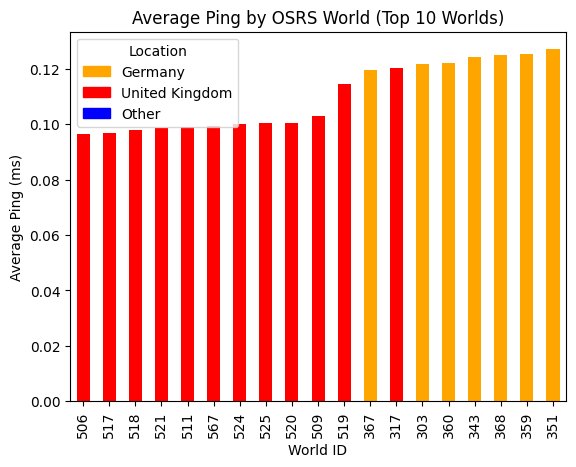

In [46]:
import pandas as pd
from utils import schema
import sqlalchemy as sa
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# create the database
engine = sa.create_engine("sqlite:///data/world_data.db")
schema.Base.metadata.create_all(engine)
# insert the data into the database
with schema.get_session(engine=engine) as session:
    ping_data = session.query(schema.PingData).all()
    df = pd.DataFrame([x.to_dict() for x in ping_data])
    # plot the data for the lowest average ping for the top 10 worlds
    top10 = df.groupby("world_id").agg(count=("ping", "size"), ping=("ping", "mean"), players=("players", "mean")).sort_values("ping").head(20)
    top10["world_id"] = top10.index
    top10["db_obj"] = [session.query(schema.PingData).filter(schema.PingData.world_id == x).first() for x in top10.index]
    top10["location"] = [x.world.location for x in top10["db_obj"]]
    # mean().sort_values("ping").head(10)
    # colour the bars by world.location
    colours = []
    for location in top10["location"]:
        if location == "Germany":
            colours.append("orange")
        elif location == "United Kingdom":
            colours.append("red")
        else:
            colours.append("blue")
    ax = top10.plot(kind="bar", y="ping", color=colours)
    handles, labels = ax.get_legend_handles_labels()
    # add a legend, force it to have 3 entries (one for each location)
    patches = [mpatches.Patch(color="orange", label="Germany"), mpatches.Patch(color="red", label="United Kingdom"), mpatches.Patch(color="blue", label="Other")]
    plt.legend(handles=patches, labels=["Germany", "United Kingdom", "Other"], title="Location")
    # add labels with the number of data points for each world
    # for i, v in enumerate(zip(top10["ping"], top10["count"], top10["players"])):
    #     world_id = int(top10.index[i])
    #     # add a label at the top of each bar with the number of data points used to calculate the average
    #     # ax.text(i, v[0], f"({v[1]}n)", ha="center", va="bottom")
    #     ping_data_obj = session.query(schema.PingData).filter(schema.PingData.world_id == world_id).first()
    #     world = ping_data_obj.world
    #     # also add the world activity inside the bar, this is taken from the relation from world_id
    #     # rotate the text so it is easier to read
    #     ax.text(i, v[0], f"{world.location} (Avg. {int(v[2])} pop)", ha="center", va="top", rotation=90)
    #     # colour the bars by world.location
    #     if world.location == "Germany":
    #         ax.patches[i].set_facecolor("orange")
    #     elif world.location == "United Kingdom":
    #         ax.patches[i].set_facecolor("red")
    plt.ylabel("Average Ping (ms)")
    plt.title(f"Average Ping by OSRS World (Top 10 Worlds)")
    plt.xlabel("World ID")
    plt.show()

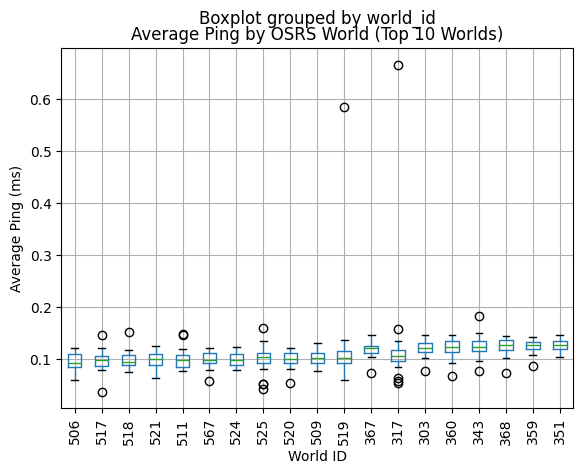

In [47]:
# create a box plot of each of the top 10 worlds
with schema.get_session(engine=engine) as session:
    ping_data = session.query(schema.PingData).all()
    df = pd.DataFrame([x.to_dict() for x in ping_data])
    # plot the data for the lowest average ping for the top 10 worlds
    topping = df.groupby("world_id").agg(count=("ping", "size"), ping=("ping", "mean"), players=("players", "mean")).sort_values("ping").head(20)
    # mean().sort_values("ping").head(10)
    sliced_df = df[df["world_id"].isin(topping.index)]
    sliced_df["ping_db_objs"] = sliced_df["world_id"].apply(lambda x: session.query(schema.PingData).filter(schema.PingData.world_id == x).all())
    # sort the data by the topping dataframe
    sliced_df["world_id"] = pd.Categorical(sliced_df["world_id"], categories=topping.index, ordered=True)
    # plot the boxplot coloured by world location
    ax = sliced_df.boxplot(column="ping", by="world_id", rot=90)
    plt.ylabel("Average Ping (ms)")
    plt.title(f"Average Ping by OSRS World (Top 10 Worlds)")
    plt.xlabel("World ID")
    plt.show()

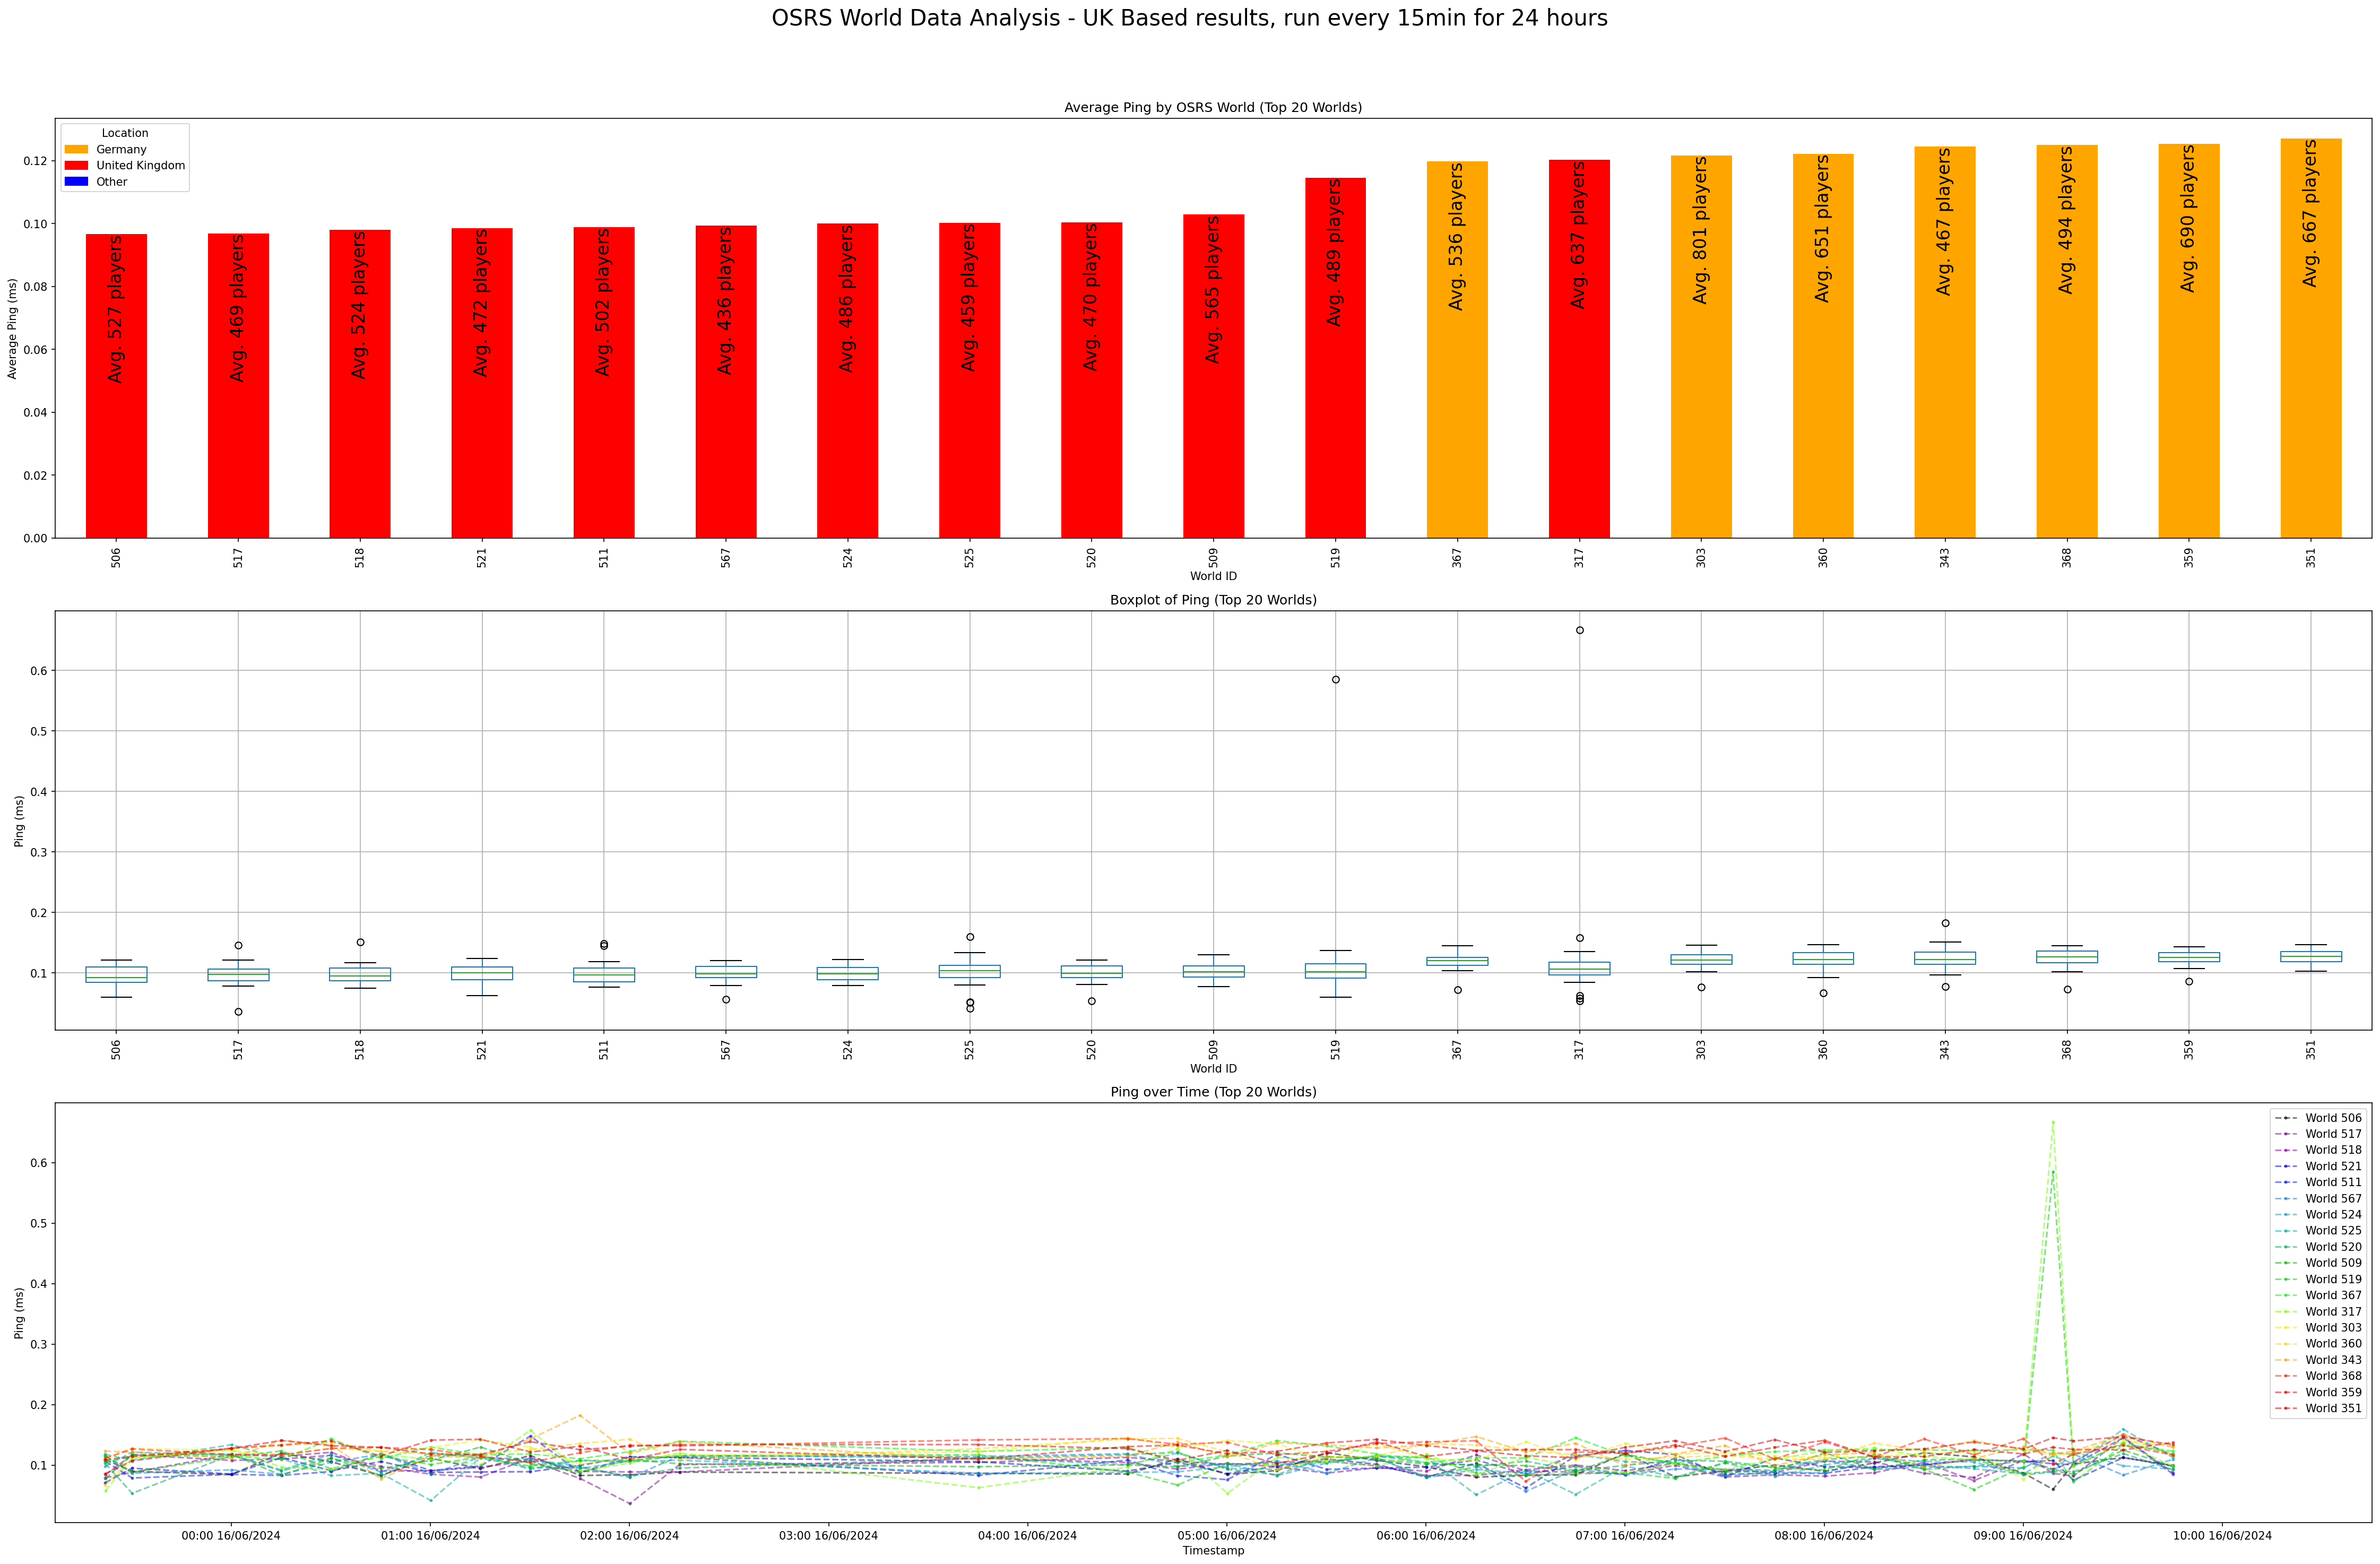

In [65]:
# combine both plots into subplots on a single figure, with figure size 20x10
import numpy as np


fig, ax = plt.subplots(3, 1, figsize=(30, 20))
fig.set_dpi(150)
# plot the bar chart, coloured by world location
top10.plot(kind="bar", y="ping", legend=False, ax=ax[0], color=colours)
for i, v in enumerate(zip(top10["ping"], top10["count"], top10["players"])):
        # also add the world activity inside the bar, this is taken from the relation from world_id
        ax[0].text(i, v[0], f"Avg. {int(v[2])} players", ha="center", va="top", rotation=90, fontsize=16)
# add the legend
ax[0].legend(handles=patches, labels=["Germany", "United Kingdom", "Other"], title="Location")
# plot the boxplot
sliced_df.boxplot(column="ping", by="world_id", rot=90, ax=ax[1])
# ax[1].set_ylim(0, 0.3)
number_of_plots=20
colormap = plt.cm.nipy_spectral #I suggest to use nipy_spectral, Set1,Paired
ax[2].set_prop_cycle(color=[colormap(i) for i in np.linspace(0, 1,number_of_plots)])
# add a lineplot for the ping over timestamp for the top 10 worlds
for i, world_id in enumerate(top10.index):
    world_df = df[df["world_id"] == world_id]
    ax[2].plot(world_df["timestamp"], world_df["ping"], label=f"World {world_id}", alpha=0.5, marker="o", linestyle="--", markersize=2)
    ax[2].set_xlabel("Timestamp")
    ax[2].set_ylabel("Ping (ms)")
    ax[2].legend(loc="upper right")
    # add a buffer to the x-axis so the labels are not cut off
    ax[2].set_xlim(world_df["timestamp"].min() - pd.Timedelta(minutes=15), world_df["timestamp"].max() + pd.Timedelta(minutes=60))
    # set the x-axis to be in HH:MM dd/mm/yyyy format
    ax[2].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%H:%M %d/%m/%Y"))
# ax[2].set_ylim(0, 0.2)
# add margins to the figure
fig.suptitle("OSRS World Data Analysis - UK Based results, run every 15min for 24 hours", fontsize=20)
ax[0].set_title("Average Ping by OSRS World (Top 20 Worlds)")
ax[0].set_xlabel("World ID")
ax[0].set_ylabel("Average Ping (ms)")
ax[1].set_title("Boxplot of Ping (Top 20 Worlds)")
ax[1].set_xlabel("World ID")
ax[1].set_ylabel("Ping (ms)")
ax[2].set_title("Ping over Time (Top 20 Worlds)")
ax[2].set_xlabel("Timestamp")
ax[2].set_ylabel("Ping (ms)")
fig.tight_layout(rect=[0, 0, 1, 0.95])